# Transformers from scratch

Following this article:

A Complete Guide to Write your own Transformers - Benjamin Etienne, Feb 24, 2024

[https://towardsdatascience.com/a-complete-guide-to-write-your-own-transformers-29e23f371ddd](https://towardsdatascience.com/a-complete-guide-to-write-your-own-transformers-29e23f371ddd)


## Multi-Head Attention

In [2]:
import torch
import torch.nn as nn
import math


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim=256, num_heads=4):
        """
        input_dim: Dimensionality of the input.
        num_heads: The number of attention heads to split the input into.
        """
        super(MultiHeadAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        assert hidden_dim % num_heads == 0, "Hidden dim must be divisible by num heads"
        self.Wv = nn.Linear(hidden_dim, hidden_dim, bias=False) # the Value part
        self.Wk = nn.Linear(hidden_dim, hidden_dim, bias=False) # the Key part
        self.Wq = nn.Linear(hidden_dim, hidden_dim, bias=False) # the Query part
        self.Wo = nn.Linear(hidden_dim, hidden_dim, bias=False) # the output layer
        
        
    def check_sdpa_inputs(self, x):
        assert x.size(1) == self.num_heads, f"Expected size of x to be ({-1, self.num_heads, -1, self.hidden_dim // self.num_heads}), got {x.size()}"
        assert x.size(3) == self.hidden_dim // self.num_heads
        
        
    def scaled_dot_product_attention(
            self, 
            query, 
            key, 
            value, 
            attention_mask=None, 
            key_padding_mask=None):
        """
        query : tensor of shape (batch_size, num_heads, query_sequence_length, hidden_dim//num_heads)
        key : tensor of shape (batch_size, num_heads, key_sequence_length, hidden_dim//num_heads)
        value : tensor of shape (batch_size, num_heads, key_sequence_length, hidden_dim//num_heads)
        attention_mask : tensor of shape (query_sequence_length, key_sequence_length)
        key_padding_mask : tensor of shape (sequence_length, key_sequence_length)
        
    
        """
        self.check_sdpa_inputs(query)
        self.check_sdpa_inputs(key)
        self.check_sdpa_inputs(value)
        
        
        d_k = query.size(-1)
        tgt_len, src_len = query.size(-2), key.size(-2)

        
        # logits = (B, H, tgt_len, E) * (B, H, E, src_len) = (B, H, tgt_len, src_len)
        logits = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) 
        
        # Attention mask here
        if attention_mask is not None:
            if attention_mask.dim() == 2:
                assert attention_mask.size() == (tgt_len, src_len)
                attention_mask = attention_mask.unsqueeze(0)
                logits = logits + attention_mask
            else:
                raise ValueError(f"Attention mask size {attention_mask.size()}")
        
                
        # Key mask here
        if key_padding_mask is not None:
            key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(2) # Broadcast over batch size, num heads
            logits = logits + key_padding_mask
        
        
        attention = torch.softmax(logits, dim=-1)
        output = torch.matmul(attention, value) # (batch_size, num_heads, sequence_length, hidden_dim)
        
        return output, attention

    
    def split_into_heads(self, x, num_heads):
        batch_size, seq_length, hidden_dim = x.size()
        x = x.view(batch_size, seq_length, num_heads, hidden_dim // num_heads)
        
        return x.transpose(1, 2) # Final dim will be (batch_size, num_heads, seq_length, , hidden_dim // num_heads)

    def combine_heads(self, x):
        batch_size, num_heads, seq_length, head_hidden_dim = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, num_heads * head_hidden_dim)
        
    
    def forward(
            self, 
            q, 
            k, 
            v, 
            attention_mask=None, 
            key_padding_mask=None):
        """
        q : tensor of shape (batch_size, query_sequence_length, hidden_dim)
        k : tensor of shape (batch_size, key_sequence_length, hidden_dim)
        v : tensor of shape (batch_size, key_sequence_length, hidden_dim)
        attention_mask : tensor of shape (query_sequence_length, key_sequence_length)
        key_padding_mask : tensor of shape (sequence_length, key_sequence_length)
       
        """
        q = self.Wq(q)
        k = self.Wk(k)
        v = self.Wv(v)

        q = self.split_into_heads(q, self.num_heads)
        k = self.split_into_heads(k, self.num_heads)
        v = self.split_into_heads(v, self.num_heads)
        
        # attn_values, attn_weights = self.multihead_attn(q, k, v, attn_mask=attention_mask)
        attn_values, attn_weights  = self.scaled_dot_product_attention(
            query=q, 
            key=k, 
            value=v, 
            attention_mask=attention_mask,
            key_padding_mask=key_padding_mask,
        )
        grouped = self.combine_heads(attn_values)
        output = self.Wo(grouped)
        
        self.attention_weigths = attn_weights
        
        return output

## Positional Encoding

In [3]:
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return x

## Encoders

### Feed forward module, then full encoder module

In [4]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [5]:
class EncoderBlock(nn.Module):
    def __init__(self, n_dim: int, dropout: float, n_heads: int):
        super(EncoderBlock, self).__init__()
        self.mha = MultiHeadAttention(hidden_dim=n_dim, num_heads=n_heads)
        self.norm1 = nn.LayerNorm(n_dim)
        self.ff = PositionWiseFeedForward(n_dim, n_dim)
        self.norm2 = nn.LayerNorm(n_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, src_padding_mask=None):
        assert x.ndim==3, "Expected input to be 3-dim, got {}".format(x.ndim)
        att_output = self.mha(x, x, x, key_padding_mask=src_padding_mask)
        x = x + self.dropout(self.norm1(att_output))
        
        ff_output = self.ff(x)
        output = x + self.norm2(ff_output)
       
        return output

As shown in the diagram, the Encoder actually contains N Encoder blocks or layers, as well as an Embedding layer for our inputs. Let’s therefore create an Encoder by adding the Embedding, the Positional Encoding and the Encoder blocks:

In [6]:
class Encoder(nn.Module):
    def __init__(
            self, 
            vocab_size: int, 
            n_dim: int, 
            dropout: float, 
            n_encoder_blocks: int,
            n_heads: int):
        
        super(Encoder, self).__init__()
        self.n_dim = n_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=n_dim
        )
        self.positional_encoding = PositionalEncoding(
            d_model=n_dim, 
            dropout=dropout
        )    
        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(n_dim, dropout, n_heads) for _ in range(n_encoder_blocks)
        ])
        
        
    def forward(self, x, padding_mask=None):
        x = self.embedding(x) * math.sqrt(self.n_dim)
        x = self.positional_encoding(x)
        for block in self.encoder_blocks:
            x = block(x=x, src_padding_mask=padding_mask)
        return x

## Decoders

Main differences with the encoder logic:

- Here we use Masked Multi-Head Attention, which is the MHA with a causal mask (see `attention_mask=tgt_mask` in code below).

- The second attention is called cross-attention. It will uses the decoder’s query to match with the encoder’s key & values ! Beware : they can have different lengths during training, so it is usually a good practice to define clearly the expected shapes of inputs.

- And there is a part where we use the encoder’s output, called memory, with our decoder input.

In [7]:
class DecoderBlock(nn.Module):
    def __init__(self, n_dim: int, dropout: float, n_heads: int):
        super(DecoderBlock, self).__init__()
        
        # The first Multi-Head Attention has a mask to avoid looking at the future
        self.self_attention = MultiHeadAttention(hidden_dim=n_dim, num_heads=n_heads)
        self.norm1 = nn.LayerNorm(n_dim)
        
        # The second Multi-Head Attention will take inputs from the encoder as key/value inputs
        self.cross_attention = MultiHeadAttention(hidden_dim=n_dim, num_heads=n_heads)
        self.norm2 = nn.LayerNorm(n_dim)
        
        self.ff = PositionWiseFeedForward(n_dim, n_dim)
        self.norm3 = nn.LayerNorm(n_dim)
        # self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, tgt, memory, tgt_mask=None, tgt_padding_mask=None, memory_padding_mask=None):
        
        masked_att_output = self.self_attention(
            q=tgt, k=tgt, v=tgt, attention_mask=tgt_mask, key_padding_mask=tgt_padding_mask)
        x1 = tgt + self.norm1(masked_att_output)
        
        cross_att_output = self.cross_attention(
            q=x1, k=memory, v=memory, attention_mask=None, key_padding_mask=memory_padding_mask)
        x2 = x1 + self.norm2(cross_att_output)
        
        ff_output = self.ff(x2)
        output = x2 + self.norm3(ff_output)

        
        return output

class Decoder(nn.Module):
    def __init__(
        self, 
        vocab_size: int, 
        n_dim: int, 
        dropout: float, 
        n_decoder_blocks: int,
        n_heads: int):
        
        super(Decoder, self).__init__()
        
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=n_dim,
            padding_idx=0
        )
        self.positional_encoding = PositionalEncoding(
            d_model=n_dim, 
            dropout=dropout
        )
          
        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(n_dim, dropout, n_heads) for _ in range(n_decoder_blocks)
        ])
        
        
    def forward(self, tgt, memory, tgt_mask=None, tgt_padding_mask=None, memory_padding_mask=None):
        x = self.embedding(tgt)
        x = self.positional_encoding(x)

        for block in self.decoder_blocks:
            x = block(
                x, 
                memory, 
                tgt_mask=tgt_mask, 
                tgt_padding_mask=tgt_padding_mask, 
                memory_padding_mask=memory_padding_mask)
        return x

## Padding and Masking

We want to exclude padding indices from the attention weights being calculated. We can therefore compute a mask as follows, both for source and target data:

`padding_mask = (x == PAD_IDX)`

For causal mask we use triangular matrix:

In [8]:
def generate_square_subsequent_mask(size: int):
      """Generate a triangular (size, size) mask. From PyTorch docs."""
      mask = (1 - torch.triu(torch.ones(size, size), diagonal=1)).bool()
      mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
      return mask

In [9]:
generate_square_subsequent_mask(3)

tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])

## Case study : a Word-Reverse Transformer

Let’s now build our Transformer by bringing parts together !

In our use case, we will use a very simple dataset to showcase how Transformers actually learn.

The objective here is to see whether the Transformer attention mechanism works. What we expect is to see attention weights to move from right to left when given an input sequence. If so, this means our Transformer has learned a very simple grammar, which is just reading from right to left, and could generalize to more complex grammars when doing real-life language translation.

## Custom Transformer class

In [11]:
class Transformer(nn.Module):
    def __init__(self, **kwargs):
        super(Transformer, self).__init__()
        
        for k, v in kwargs.items():
            print(f" * {k}={v}")
        
        self.vocab_size = kwargs.get('vocab_size')
        self.model_dim = kwargs.get('model_dim')
        self.dropout = kwargs.get('dropout')
        self.n_encoder_layers = kwargs.get('n_encoder_layers')
        self.n_decoder_layers = kwargs.get('n_decoder_layers')
        self.n_heads = kwargs.get('n_heads')
        self.batch_size = kwargs.get('batch_size')
        self.PAD_IDX = kwargs.get('pad_idx', 0)

        self.encoder = Encoder(
            self.vocab_size, self.model_dim, self.dropout, self.n_encoder_layers, self.n_heads)
        self.decoder = Decoder(
            self.vocab_size, self.model_dim, self.dropout, self.n_decoder_layers, self.n_heads)
        self.fc = nn.Linear(self.model_dim, self.vocab_size)
        

    @staticmethod    
    def generate_square_subsequent_mask(size: int):
            """Generate a triangular (size, size) mask. From PyTorch docs."""
            mask = (1 - torch.triu(torch.ones(size, size), diagonal=1)).bool()
            mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
            return mask


    def encode(
            self, 
            x: torch.Tensor, 
        ) -> torch.Tensor:
        """
        Input
            x: (B, S) with elements in (0, C) where C is num_classes
        Output
            (B, S, E) embedding
        """

        mask = (x == self.PAD_IDX).float()
        encoder_padding_mask = mask.masked_fill(mask == 1, float('-inf'))
        
        # (B, S, E)
        encoder_output = self.encoder(
            x, 
            padding_mask=encoder_padding_mask
        )  
        
        return encoder_output, encoder_padding_mask
    
    
    def decode(
            self, 
            tgt: torch.Tensor, 
            memory: torch.Tensor, 
            memory_padding_mask=None
        ) -> torch.Tensor:
        """
        B = Batch size
        S = Source sequence length
        L = Target sequence length
        E = Model dimension
        
        Input
            encoded_x: (B, S, E)
            y: (B, L) with elements in (0, C) where C is num_classes
        Output
            (B, L, C) logits
        """
        
        mask = (tgt == self.PAD_IDX).float()
        tgt_padding_mask = mask.masked_fill(mask == 1, float('-inf'))

        decoder_output = self.decoder(
            tgt=tgt, 
            memory=memory, 
            tgt_mask=self.generate_square_subsequent_mask(tgt.size(1)), 
            tgt_padding_mask=tgt_padding_mask, 
            memory_padding_mask=memory_padding_mask,
        )  
        output = self.fc(decoder_output)  # shape (B, L, C)
        return output

        
        
    def forward(
            self, 
            x: torch.Tensor, 
            y: torch.Tensor, 
        ) -> torch.Tensor:
        """
        Input
            x: (B, Sx) with elements in (0, C) where C is num_classes
            y: (B, Sy) with elements in (0, C) where C is num_classes
        Output
            (B, L, C) logits
        """
        
        # Encoder output shape (B, S, E)
        encoder_output, encoder_padding_mask = self.encode(x)  

        # Decoder output shape (B, L, C)
        decoder_output = self.decode(
            tgt=y, 
            memory=encoder_output, 
            memory_padding_mask=encoder_padding_mask
        )  
        
        return decoder_output

## Inference with greedy decoding

In [12]:
def predict(
            self,
            x: torch.Tensor,
            sos_idx: int=1,
            eos_idx: int=2,
            max_length: int=None
        ) -> torch.Tensor:
        """
        Method to use at inference time. Predict y from x one token at a time. This method is greedy
        decoding. Beam search can be used instead for a potential accuracy boost.

        Input
            x: str
        Output
            (B, L, C) logits
        """

        # Pad the tokens with beginning and end of sentence tokens
        x = torch.cat([
            torch.tensor([sos_idx]), 
            x, 
            torch.tensor([eos_idx])]
        ).unsqueeze(0)

        encoder_output, mask = self.transformer.encode(x) # (B, S, E)
        
        if not max_length:
            max_length = x.size(1)

        outputs = torch.ones((x.size()[0], max_length)).type_as(x).long() * sos_idx
        for step in range(1, max_length):
            y = outputs[:, :step]
            probs = self.transformer.decode(y, encoder_output)
            output = torch.argmax(probs, dim=-1)
            
            # Uncomment if you want to see step by step predicitons
            # print(f"Knowing {y} we output {output[:, -1]}")

            if output[:, -1].detach().numpy() in (eos_idx, sos_idx):
                break
            outputs[:, step] = output[:, -1]
            
        
        return outputs

## Create toy dataset of reversed words

In [14]:
import numpy as np
import torch
from torch.utils.data import Dataset


np.random.seed(0)

def generate_random_string():
    len = np.random.randint(10, 20)
    return "".join([chr(x) for x in np.random.randint(97, 97+26, len)])

class ReverseDataset(Dataset):
    def __init__(self, n_samples, pad_idx, sos_idx, eos_idx):
        super(ReverseDataset, self).__init__()
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.values = [generate_random_string() for _ in range(n_samples)]
        self.labels = [x[::-1] for x in self.values]

    def __len__(self):
        return len(self.values)  # number of samples in the dataset

    def __getitem__(self, index):
        return self.text_transform(self.values[index].rstrip("\n")), \
            self.text_transform(self.labels[index].rstrip("\n"))
        
    def text_transform(self, x):
        return torch.tensor([self.sos_idx] + [ord(z)-97+3 for z in x] + [self.eos_idx])

## Training setup

In [15]:
PAD_IDX = 0
SOS_IDX = 1
EOS_IDX = 2

def train(model, optimizer, loader, loss_fn, epoch):
    model.train()
    losses = 0
    acc = 0
    history_loss = []
    history_acc = [] 

    with tqdm(loader, position=0, leave=True) as tepoch:
        for x, y in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            optimizer.zero_grad()
            logits = model(x, y[:, :-1])
            loss = loss_fn(logits.contiguous().view(-1, model.vocab_size), y[:, 1:].contiguous().view(-1))
            loss.backward()
            optimizer.step()
            losses += loss.item()
            
            preds = logits.argmax(dim=-1)
            masked_pred = preds * (y[:, 1:]!=PAD_IDX)
            accuracy = (masked_pred == y[:, 1:]).float().mean()
            acc += accuracy.item()
            
            history_loss.append(loss.item())
            history_acc.append(accuracy.item())
            tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy.item())

    return losses / len(list(loader)), acc / len(list(loader)), history_loss, history_acc


def evaluate(model, loader, loss_fn):
    model.eval()
    losses = 0
    acc = 0
    history_loss = []
    history_acc = [] 

    for x, y in tqdm(loader, position=0, leave=True):

        logits = model(x, y[:, :-1])
        loss = loss_fn(logits.contiguous().view(-1, model.vocab_size), y[:, 1:].contiguous().view(-1))
        losses += loss.item()
        
        preds = logits.argmax(dim=-1)
        masked_pred = preds * (y[:, 1:]!=PAD_IDX)
        accuracy = (masked_pred == y[:, 1:]).float().mean()
        acc += accuracy.item()
        
        history_loss.append(loss.item())
        history_acc.append(accuracy.item())

    return losses / len(list(loader)), acc / len(list(loader)), history_loss, history_acc

## Training args and training

In [21]:
# NOTE: these 4 lines are missing from the code in the tutorial
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import time
from tqdm import *

def collate_fn(batch):
    """ 
    This function pads inputs with PAD_IDX to have batches of equal length
    """
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

# Model hyperparameters
args = {
    'vocab_size': 128,
    'model_dim': 128,
    'dropout': 0.1,
    'n_encoder_layers': 1,
    'n_decoder_layers': 1,
    'n_heads': 4
}

# Define model here
model = Transformer(**args)

# Instantiate datasets
train_iter = ReverseDataset(50000, pad_idx=PAD_IDX, sos_idx=SOS_IDX, eos_idx=EOS_IDX)
eval_iter = ReverseDataset(10000, pad_idx=PAD_IDX, sos_idx=SOS_IDX, eos_idx=EOS_IDX)
dataloader_train = DataLoader(train_iter, batch_size=256, collate_fn=collate_fn)
dataloader_val = DataLoader(eval_iter, batch_size=256, collate_fn=collate_fn)

# During debugging, we ensure sources and targets are indeed reversed
# s, t = next(iter(dataloader_train))
# print(s[:4, ...])
# print(t[:4, ...])
# print(s.size())

# Initialize model parameters
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Define loss function : we ignore logits which are padding tokens
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

# Save history to dictionnary
history = {
    'train_loss': [],
    'eval_loss': [],
    'train_acc': [],
    'eval_acc': []
}

# Main loop
for epoch in range(1, 4):
    start_time = time.time()
    train_loss, train_acc, hist_loss, hist_acc = train(model, optimizer, dataloader_train, loss_fn, epoch)
    history['train_loss'] += hist_loss
    history['train_acc'] += hist_acc
    end_time = time.time()
    val_loss, val_acc, hist_loss, hist_acc = evaluate(model, dataloader_val, loss_fn)
    history['eval_loss'] += hist_loss
    history['eval_acc'] += hist_acc
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))

 * vocab_size=128
 * model_dim=128
 * dropout=0.1
 * n_encoder_layers=1
 * n_decoder_layers=1
 * n_heads=4


100%|██████████| 40/40 [00:02<00:00, 19.98it/s]


Epoch: 1, Train loss: 1.670, Train acc: 0.594, Val loss: 0.097, Val acc: 0.978 Epoch time = 27.347s


100%|██████████| 40/40 [00:01<00:00, 20.20it/s]


Epoch: 2, Train loss: 0.070, Train acc: 0.983, Val loss: 0.002, Val acc: 1.000 Epoch time = 27.352s


100%|██████████| 40/40 [00:01<00:00, 20.31it/s]


Epoch: 3, Train loss: 0.043, Train acc: 0.991, Val loss: 0.001, Val acc: 1.000 Epoch time = 27.224s


## Visualize attention

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

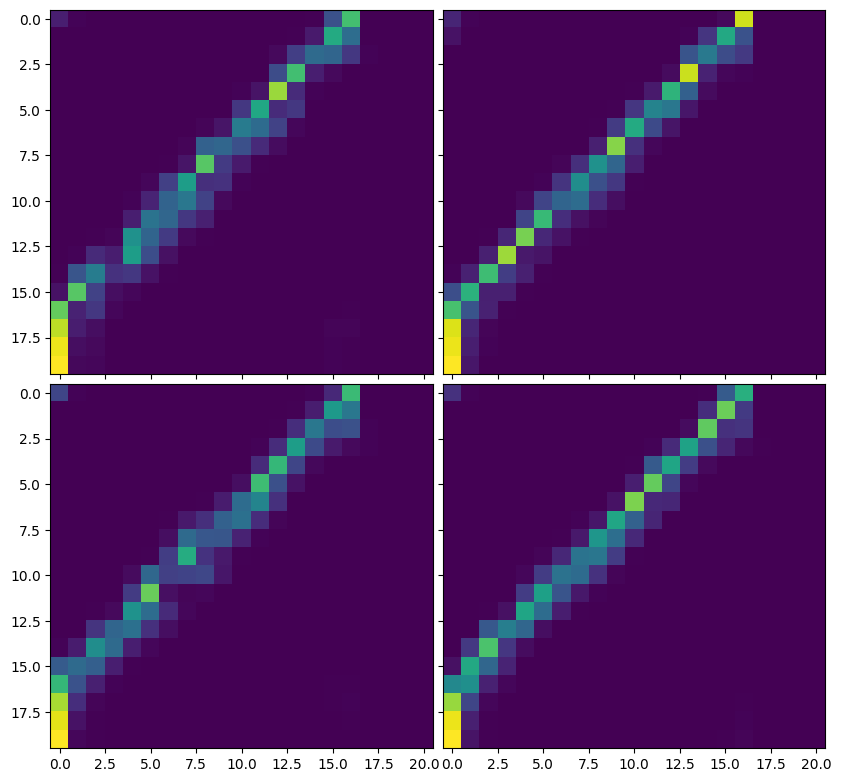

In [26]:
fig = plt.figure(figsize=(10., 10.))
images = model.decoder.decoder_blocks[0].cross_attention.attention_weigths[0,...].detach().numpy()
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                axes_pad=0.1,  # pad between axes in inch.
                )

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

## Testing the model

To test our model with new data, we will define a little `Translator` class to help us with the decoding

In [27]:
class Translator(nn.Module):
    def __init__(self, transformer):
        super(Translator, self).__init__()
        self.transformer = transformer
    
    @staticmethod
    def str_to_tokens(s):
        return [ord(z)-97+3 for z in s]
    
    @staticmethod
    def tokens_to_str(tokens):
        return "".join([chr(x+94) for x in tokens])
    
    def __call__(self, sentence, max_length=None, pad=False):
        
        x = torch.tensor(self.str_to_tokens(sentence))
        x = torch.cat([torch.tensor([SOS_IDX]), x, torch.tensor([EOS_IDX])]).unsqueeze(0)
        
        encoder_output, mask = self.transformer.encode(x) # (B, S, E)
        
        if not max_length:
            max_length = x.size(1)
            
        outputs = torch.ones((x.size()[0], max_length)).type_as(x).long() * SOS_IDX
        
        for step in range(1, max_length):
            y = outputs[:, :step]
            probs = self.transformer.decode(y, encoder_output)
            output = torch.argmax(probs, dim=-1)
            print(f"Knowing {y} we output {output[:, -1]}")
            if output[:, -1].detach().numpy() in (EOS_IDX, SOS_IDX):
                break
            outputs[:, step] = output[:, -1]
            
        
        return self.tokens_to_str(outputs[0])

In [34]:
translator = Translator(model)
sentence = "reversethis"
out = translator(sentence, pad=False)
print(out)

Knowing tensor([[1]]) we output tensor([21])
Knowing tensor([[ 1, 21]]) we output tensor([11])
Knowing tensor([[ 1, 21, 11]]) we output tensor([10])
Knowing tensor([[ 1, 21, 11, 10]]) we output tensor([22])
Knowing tensor([[ 1, 21, 11, 10, 22]]) we output tensor([7])
Knowing tensor([[ 1, 21, 11, 10, 22,  7]]) we output tensor([21])
Knowing tensor([[ 1, 21, 11, 10, 22,  7, 21]]) we output tensor([20])
Knowing tensor([[ 1, 21, 11, 10, 22,  7, 21, 20]]) we output tensor([7])
Knowing tensor([[ 1, 21, 11, 10, 22,  7, 21, 20,  7]]) we output tensor([24])
Knowing tensor([[ 1, 21, 11, 10, 22,  7, 21, 20,  7, 24]]) we output tensor([7])
Knowing tensor([[ 1, 21, 11, 10, 22,  7, 21, 20,  7, 24,  7]]) we output tensor([20])
Knowing tensor([[ 1, 21, 11, 10, 22,  7, 21, 20,  7, 24,  7, 20]]) we output tensor([2])
_sihtesrever_


## Attention head

We can clearly see that the model attends from right to left when inverting our sentence “reversethis” ! (The step 0 actually receives the beginning of sentence token).

<Figure size 640x480 with 0 Axes>

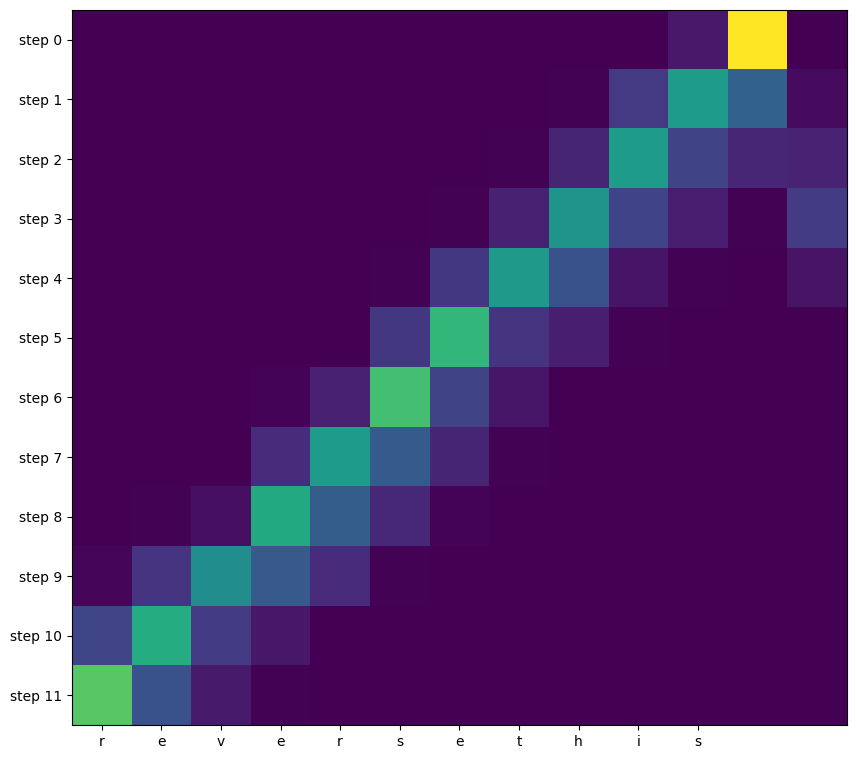

In [35]:
fig = plt.figure()
images = model.decoder.decoder_blocks[0].cross_attention.attention_weigths[0,...].detach().numpy().mean(axis=0)

fig, ax = plt.subplots(1,1, figsize=(10., 10.))
# Iterating over the grid returs the Axes.
ax.set_yticks(range(len(out)))
ax.set_xticks(range(len(sentence)))

ax.xaxis.set_label_position('top') 

ax.set_xticklabels(iter(sentence))
ax.set_yticklabels([f"step {i}" for i in range(len(out))])
ax.imshow(images)